# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импортируем все необходимые библиотеки в одной ячейке

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phik

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

Загружаем данные

In [3]:
region_1 = pd.read_csv('/datasets/geo_data_0.csv')
region_2 = pd.read_csv('/datasets/geo_data_1.csv')
region_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
region_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
region_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
region_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Все столбцы имеют корректное название. Изучим общую информацию о датасетах

In [7]:
region_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В датасете с первым регионом 100000 строк, пропусков нет. Все столбцы имеют корректный тип данных

In [8]:
region_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Для второго региона ситуация аналогична с первым регионом

In [9]:
region_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Здесь тоже все в порядке. Перейдем к предобработке данных. Для начала проверим наличие явных дубликатов 

In [10]:
region_1.duplicated().sum()

0

In [11]:
region_2.duplicated().sum()

0

In [12]:
region_3.duplicated().sum()

0

Явных дубликатов нет. Проверим на наличие неявных дубликатов, таковые могут храниться только в столбце с id

In [13]:
region_1[region_1.duplicated(subset='id', keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


Видим несколько дубликатов, возможно они появились в связи с тем, что на данных месторождениях велись новые измерения. Удалим дубликаты, оставив первое вхождение id. Можем удалить, так как они составляют малую часть от общей выборки

In [14]:
region_1 = region_1.drop_duplicates(subset='id', keep='first')

In [15]:
region_1[region_1.duplicated(subset='id', keep=False)].sort_values(by='id')

,id,f0,f1,f2,product


Проведем аналогичную работу для двух других регионов

In [16]:
region_2[region_2.duplicated(subset='id', keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [17]:
region_2 = region_2.drop_duplicates(subset='id', keep='first')

In [18]:
region_3[region_3.duplicated(subset='id', keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


In [19]:
region_3 = region_3.drop_duplicates(subset='id', keep='first')

Как было отмечено выше, все столбцы имеют корректное название и корректный тип данных. Так же, отсутствуют пропуски, поэтому перейдем к исследовательскому анализу данных

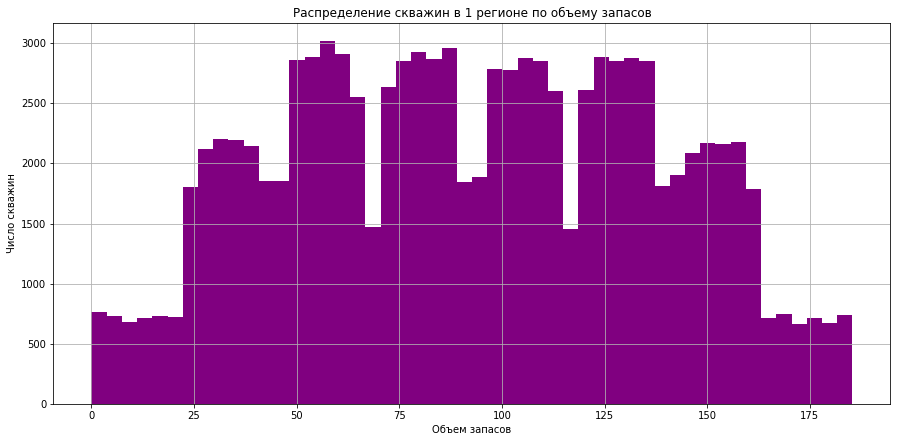

In [20]:
region_1['product'].hist(figsize=(15, 7), bins=50, color='purple')
plt.xlabel('Объем запасов')
plt.ylabel('Число скважин')
plt.title('Распределение скважин в 1 регионе по объему запасов')
plt.show()

Аномальных и выбивающихся значений в распределении не обнаружено. Значение запасов равное 0 должно быть возможным. Распределение чем-то смахивает на нормальное, но имеется несколько пиков внутри самого распределения

In [21]:
region_1['product'].describe()

count    99990.000000
mean        92.499684
std         44.288304
min          0.000000
25%         56.497069
50%         91.847928
75%        128.563699
max        185.364347
Name: product, dtype: float64

Проделаем аналогичную работу для второго региона

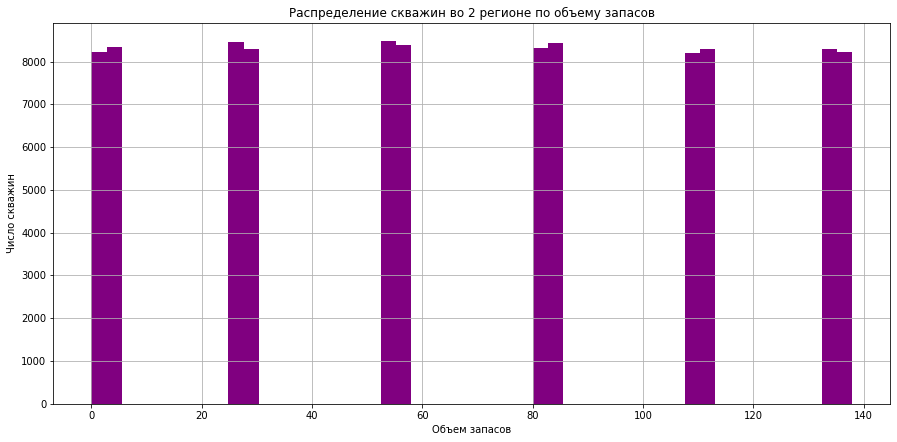

In [22]:
region_2['product'].hist(figsize=(15, 7), bins=50, color='purple')
plt.xlabel('Объем запасов')
plt.ylabel('Число скважин')
plt.title('Распределение скважин во 2 регионе по объему запасов')
plt.show()

Здесь наблюдаем четкие "колонны" по объемам. То есть все месторождения разделились на 6 категорий по объему запасов в них, такого не должно быть, учитывая, что запасы есть непрерывная переменная исходя из логики

In [23]:
region_2['product'].describe()

count    99996.000000
mean        68.823916
std         45.944663
min          0.000000
25%         26.953261
50%         57.085625
75%        107.813044
max        137.945408
Name: product, dtype: float64

Смотрим для третьего региона

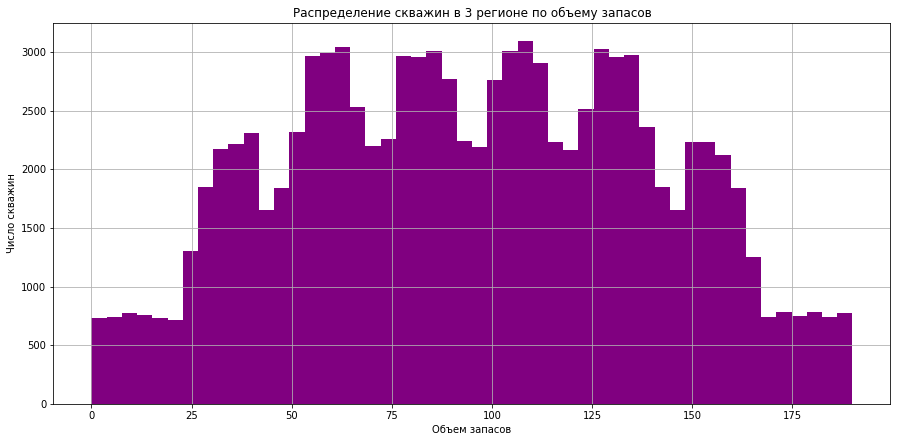

In [24]:
region_3['product'].hist(figsize=(15, 7), bins=50, color='purple')
plt.xlabel('Объем запасов')
plt.ylabel('Число скважин')
plt.title('Распределение скважин в 3 регионе по объему запасов')
plt.show()

Здесь распределение имеет схожий вид с первым регионом. Аномальных значений и выбросов так же не обнаружено

In [25]:
region_3['product'].describe()

count    99996.000000
mean        94.998342
std         44.749573
min          0.000000
25%         59.450028
50%         94.925026
75%        130.586815
max        190.029838
Name: product, dtype: float64

Проведем аналогичный анализ для параметров f0, f1, f2 во всех трех регионах

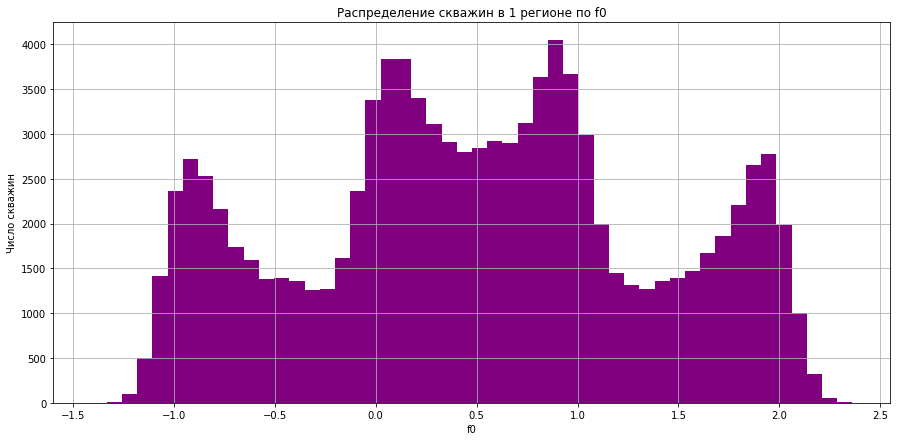

In [26]:
region_1['f0'].hist(figsize=(15, 7), bins=50, color='purple')
plt.xlabel('f0')
plt.ylabel('Число скважин')
plt.title('Распределение скважин в 1 регионе по f0')
plt.show()

Распределение имеет 4 локальных пика и значения лежат симметрично близ f0 = 0.5

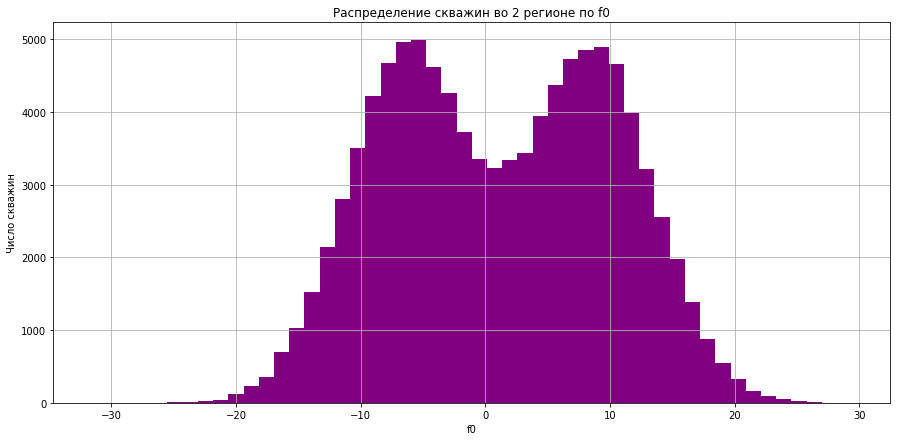

In [27]:
region_2['f0'].hist(figsize=(15, 7), bins=50, color='purple')
plt.xlabel('f0')
plt.ylabel('Число скважин')
plt.title('Распределение скважин во 2 регионе по f0')
plt.show()

Здесь у распределения уже 2 пика и симметрия около f0 = 0

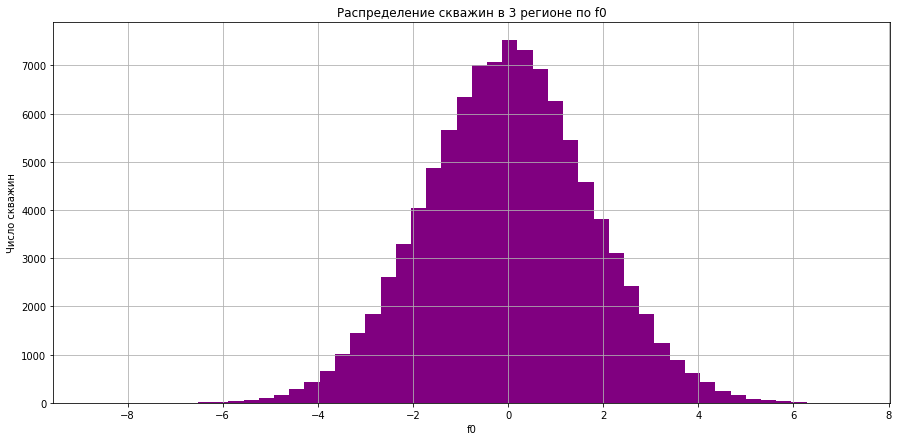

In [28]:
region_3['f0'].hist(figsize=(15, 7), bins=50, color='purple')
plt.xlabel('f0')
plt.ylabel('Число скважин')
plt.title('Распределение скважин в 3 регионе по f0')
plt.show()

Здесь наблюдаем нормальное распределение с пиком в f0 = 0

Перейдем к f1

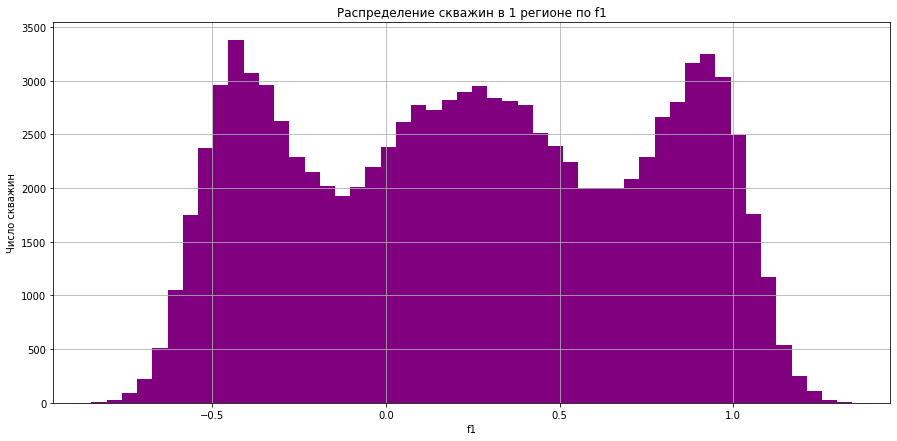

In [29]:
region_1['f1'].hist(figsize=(15, 7), bins=50, color='purple')
plt.xlabel('f1')
plt.ylabel('Число скважин')
plt.title('Распределение скважин в 1 регионе по f1')
plt.show()

Видим 3 локальных пика и симметрию относительно f1 примерно равного 0.25

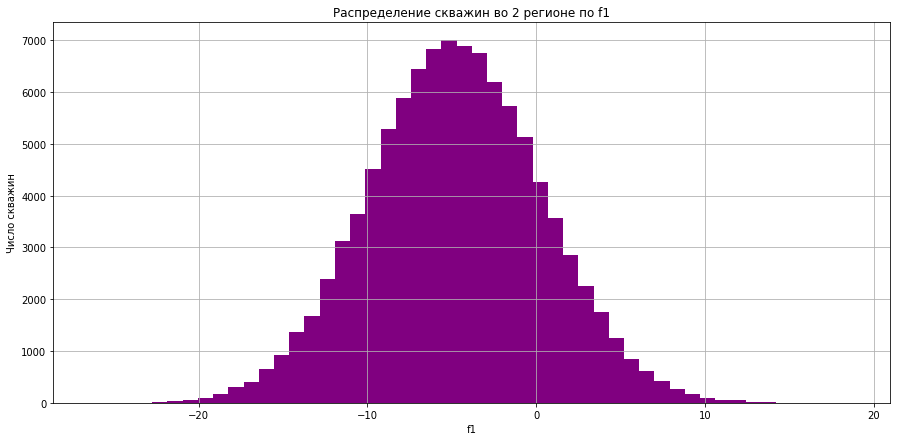

In [30]:
region_2['f1'].hist(figsize=(15, 7), bins=50, color='purple')
plt.xlabel('f1')
plt.ylabel('Число скважин')
plt.title('Распределение скважин во 2 регионе по f1')
plt.show()

Во втором регионе f1 распределено нормально вокруг значения -5

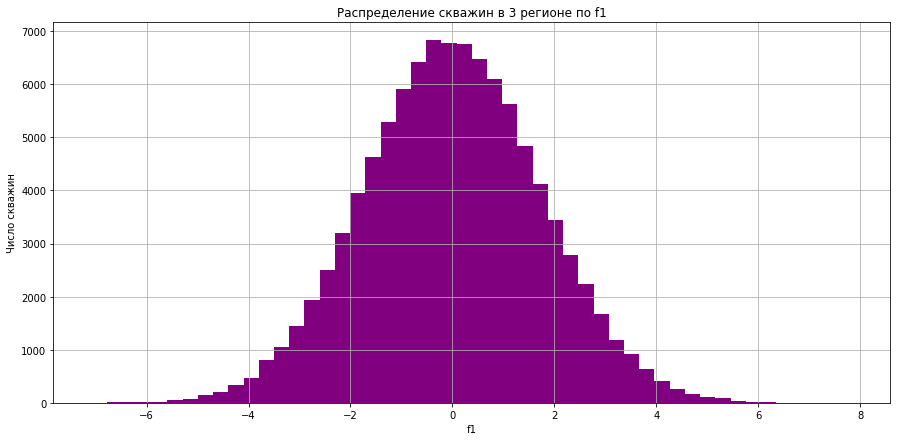

In [31]:
region_3['f1'].hist(figsize=(15, 7), bins=50, color='purple')
plt.xlabel('f1')
plt.ylabel('Число скважин')
plt.title('Распределение скважин в 3 регионе по f1')
plt.show()

Здесь так же наблюдается нормальное распределение с пиком в точке f1 = 0 

Теперь рассмотрим f2

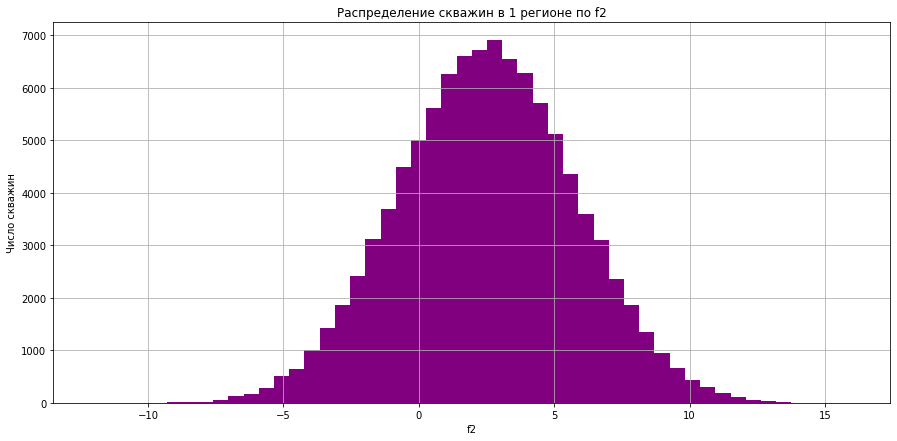

In [32]:
region_1['f2'].hist(figsize=(15, 7), bins=50, color='purple')
plt.xlabel('f2')
plt.ylabel('Число скважин')
plt.title('Распределение скважин в 1 регионе по f2')
plt.show()

Видим нормальное распределение с пиком в точке f2 = 2.5

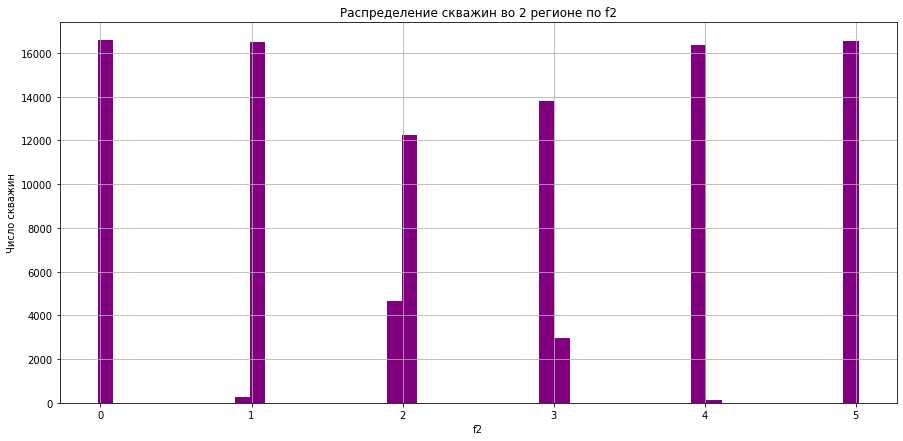

In [33]:
region_2['f2'].hist(figsize=(15, 7), bins=50, color='purple')
plt.xlabel('f2')
plt.ylabel('Число скважин')
plt.title('Распределение скважин во 2 регионе по f2')
plt.show()

Здесь снова видим 6 категорий по значению f2. Что-то подозрительное, можем предположить проблемы с оборудованием во втором регионе

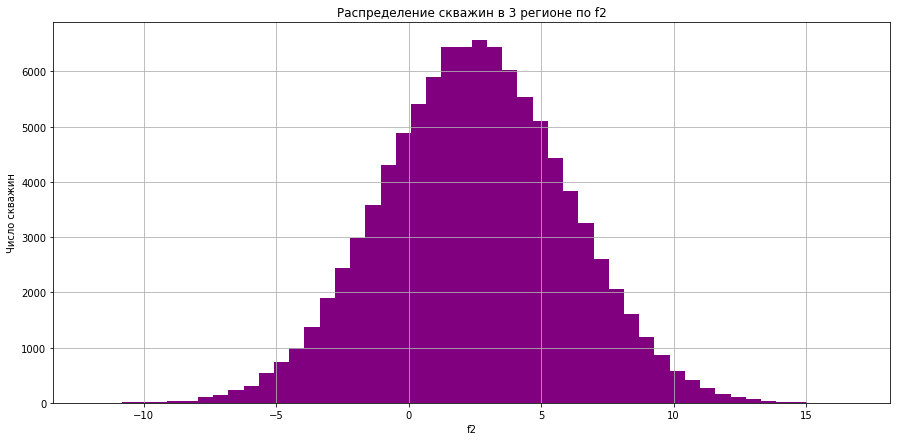

In [34]:
region_3['f2'].hist(figsize=(15, 7), bins=50, color='purple')
plt.xlabel('f2')
plt.ylabel('Число скважин')
plt.title('Распределение скважин в 3 регионе по f2')
plt.show()

Здесь снова нормальное распределение в точке f2 = 2.5

Построим матрицу корреляций для каждого региона

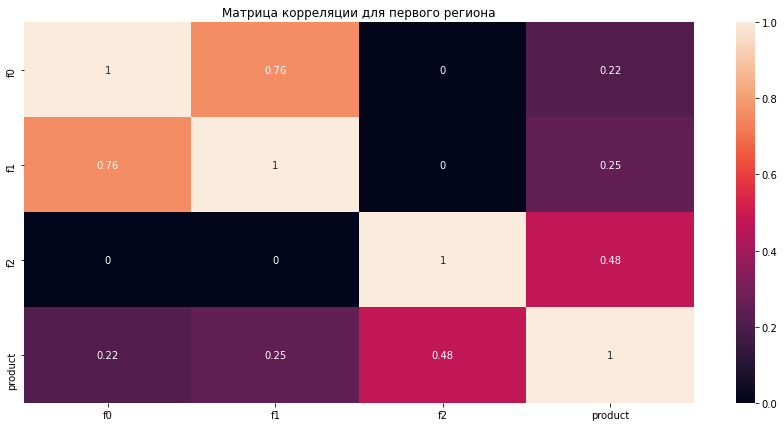

In [35]:
interval_cols = ['f0', 'f1', 'f2', 'product']

phik_corr = region_1.drop(columns=['id'], axis=1).phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(15, 7))
sns.heatmap(phik_corr, annot=True)
plt.title('Матрица корреляции для первого региона')
plt.show()

Два признака считаются коллинеарными в том случае, если коэффициент корреляции между ними составляет 0.9. Таких признаков в первом регионе не обнаружено

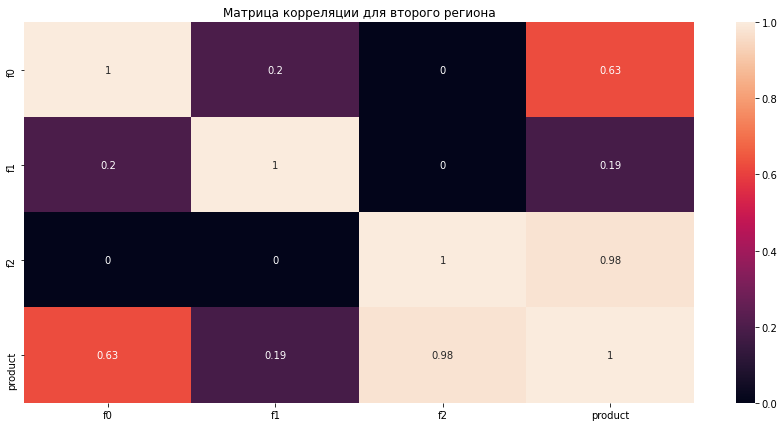

In [36]:
interval_cols = ['f0', 'f1', 'f2', 'product']

phik_corr = region_2.drop(columns=['id'], axis=1).phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(15, 7))
sns.heatmap(phik_corr, annot=True)
plt.title('Матрица корреляции для второго региона')
plt.show()

Здесь видим почти полную корреляцию между признаком f2 и целевым. Однако, по заданию все из f важные, поэтому не можем удалить. Так же, у нас мало информации касательно того, какого рода признак f2, поэтому оставляем как есть. Максимум можем предположить, что это проблемы с оборудованием

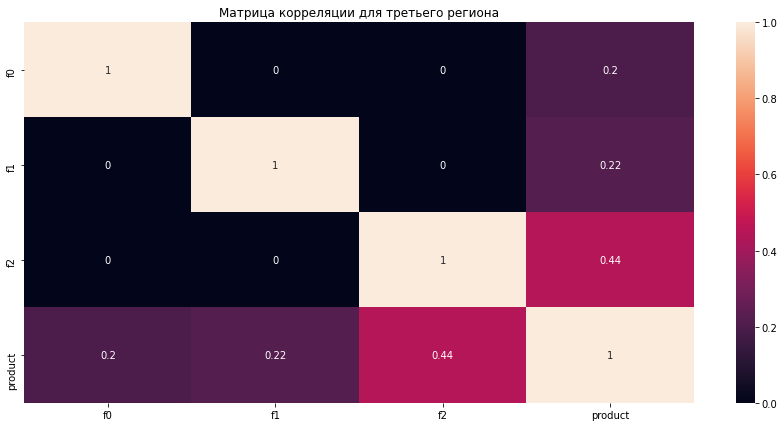

In [37]:
interval_cols = ['f0', 'f1', 'f2', 'product']

phik_corr = region_3.drop(columns=['id'], axis=1).phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(15, 7))
sns.heatmap(phik_corr, annot=True)
plt.title('Матрица корреляции для третьего региона')
plt.show()

Здесь, как и в первом регионе, все в порядке

На этом шаге мы загрузили данные трех регионов и изучили общую информацию о них. Обнаружили дубликаты по id в каждом из регионов и удалили их. Далее провели исследовательский анализ данных трех регионов по всем признакам и обнаружили большие проблемы в данных во втором регионе. Во-первых, один из признаков почти полностью коррелирует с целевым. Во-вторых, объемы запасов получились дискретными, хотя такого не может быть. Отсюда мы сделали вывод о проблемах с оборудованием во втором регионе

## Обучение и проверка модели

Перейдем к обучению модели. Разделим данные на обучающую и валидационную выборки в соотношении 75:25

In [38]:
X_1 = region_1.drop(columns=['id', 'product'], axis=1)
y_1 = region_1['product']

X_2 = region_2.drop(columns=['id', 'product'], axis=1)
y_2 = region_2['product']

X_3 = region_3.drop(columns=['id', 'product'], axis=1)
y_3 = region_3['product']

RANDOM_STATE=42

X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_1, y_1, test_size=0.25, random_state=RANDOM_STATE)

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_2, y_2, test_size=0.25, random_state=RANDOM_STATE)

X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_3, y_3, test_size=0.25, random_state=RANDOM_STATE)

Стандартизируем все количественные признаки

In [39]:
scaler_1 = StandardScaler()
scaler_2 = StandardScaler()
scaler_3 = StandardScaler()

X_train_scaled_1 = scaler_1.fit_transform(X_train_1)
X_val_scaled_1 = scaler_1.transform(X_val_1)

X_train_scaled_2 = scaler_2.fit_transform(X_train_2)
X_val_scaled_2 = scaler_2.transform(X_val_2)

X_train_scaled_3 = scaler_3.fit_transform(X_train_3)
X_val_scaled_3 = scaler_3.transform(X_val_3)

Теперь обучим модель и сделаем предсказание для каждого региона на валидационной выборке

In [40]:
model_1 = LinearRegression()
model_2 = LinearRegression()
model_3 = LinearRegression()

model_1.fit(X_train_scaled_1, y_train_1)
y_pred_1 = model_1.predict(X_val_scaled_1)

model_2.fit(X_train_scaled_2, y_train_2)
y_pred_2 = model_2.predict(X_val_scaled_2)

model_3.fit(X_train_scaled_3, y_train_3)
y_pred_3 = model_3.predict(X_val_scaled_3)

Посчитаем среднее предсказанное значение для каждого региона и посчитаем метрику RMSE

In [41]:
mse_1 = mean_squared_error(y_val_1, y_pred_1)
mse_2 = mean_squared_error(y_val_2, y_pred_2)
mse_3 = mean_squared_error(y_val_3, y_pred_3)

rmse_1 = np.sqrt(mse_1)
rmse_2 = np.sqrt(mse_2)
rmse_3 = np.sqrt(mse_3)

print(f'Среднее значение предсказанного сырья для первого региона: {y_pred_1.mean()}')
print(f'Среднее значение предсказанного сырья для второго региона: {y_pred_2.mean()}')
print(f'Среднее значение предсказанного сырья для третьего региона: {y_pred_3.mean()}')
print('\n')
print(f'Среднее значение фактического сырья для первого региона: {region_1["product"].mean()}')
print(f'Среднее значение фактического сырья для второго региона: {region_2["product"].mean()}')
print(f'Среднее значение фактического сырья для третьего региона: {region_3["product"].mean()}')
print('\n')
print(f'Метрика RMSE для первого региона: {rmse_1}')
print(f'Метрика RMSE для второго региона: {rmse_2}')
print(f'Метрика RMSE для третьего региона: {rmse_3}')

Среднее значение предсказанного сырья для первого региона: 92.60984027552017
Среднее значение предсказанного сырья для второго региона: 68.57703454115173
Среднее значение предсказанного сырья для третьего региона: 94.93478722287514


Среднее значение фактического сырья для первого региона: 92.49968421774354
Среднее значение фактического сырья для второго региона: 68.82391591804064
Среднее значение фактического сырья для третьего региона: 94.99834211933378


Метрика RMSE для первого региона: 37.68508926201444
Метрика RMSE для второго региона: 0.8928265978121422
Метрика RMSE для третьего региона: 40.080822438088305


Для второго региона получили наименьшее количество предсказанного сырья, это было выявлено еще на этапе исследовательского анализа, так как среднее значение второго региона было меньше всего. Метрика RMSE лежит около значения 40 для всех регионов, кроме второго. О всех проблемах второго региона было сказано выше

На этом этапе мы обучили три модели линейной регрессии для всех трех регионов. Посчитали метрику RMSE для каждого региона и посчитали средний запас предсказанного сырья

## Подготовка к расчёту прибыли

Для начала введем все необходимые переменные

In [42]:
budget = 10e+9
profit_all = 450000
loss_probability = 0.025
number_of_exploration_points = 500
selected_points = 200

Рассчитаем минимальный объем для безубыточной работы 

In [43]:
min_product = budget / profit_all 
min_product

22222.222222222223

Рассчитаем минимальный средний запас, приходящийся на 1 скважину

In [44]:
min_product_per_unit = min_product / selected_points
min_product_per_unit

111.11111111111111

Из пункта выше видим, что все скважины в среднем имеют меньший объем, чем нам необходимо. Поэтому нам необходимо с помощью модели избрать 200 скважин, которые способны производить больше, чем минимальный объем для безубытка

## Расчёт прибыли и рисков 

Напишем функцию, рассчитывающую прибыль для лучших 200 скважин

In [52]:
def profit(pred, true):
    
    sorted_indices = np.argsort(-pred)
    top_200_indices = sorted_indices[:200]
    
    total_volume = true[top_200_indices].sum()
    
    profit = total_volume * profit_all - budget
    
    return profit

Применим технику bootstrap, чтобы найти распределение прибыли

In [53]:
y_pred_1_array = np.array(y_pred_1)
y_val_1_array = np.array(y_val_1)

y_pred_2_array = np.array(y_pred_2)
y_val_2_array = np.array(y_val_2)

y_pred_3_array = np.array(y_pred_3)
y_val_3_array = np.array(y_val_3)

In [54]:
bootstrap_samples = 1000

profits_1 = []
profits_2 = []
profits_3 = []
np.random.seed(42)

for i in range(bootstrap_samples):
    
    
    idx = np.random.choice(len(y_pred_1), size=number_of_exploration_points, replace=True)
    sample_pred = y_pred_1_array[idx]
    sample_true = y_val_1_array[idx]
    profits_1.append(profit(sample_pred, sample_true))
    
for i in range(bootstrap_samples):
    
    idx = np.random.choice(len(y_pred_2), size=number_of_exploration_points, replace=True)
    sample_pred = y_pred_2_array[idx]
    sample_true = y_val_2_array[idx]
    profits_2.append(profit(sample_pred, sample_true))
    
for i in range(bootstrap_samples):
    
    idx = np.random.choice(len(y_pred_1), size=number_of_exploration_points, replace=True)
    sample_pred = y_pred_3_array[idx]
    sample_true = y_val_3_array[idx]
    profits_3.append(profit(sample_pred, sample_true))

Теперь найдем среднюю прибыль

In [55]:
profit_1_mean = np.mean(profits_1)
profit_2_mean = np.mean(profits_2)
profit_3_mean = np.mean(profits_3)

print(f'Средняя прибыль для первого региона: {profit_1_mean}')
print(f'Средняя прибыль для второго региона: {profit_2_mean}')
print(f'Средняя прибыль для третьего региона: {profit_3_mean}')

Средняя прибыль для первого региона: 403572063.9550541
Средняя прибыль для второго региона: 439363670.3344077
Средняя прибыль для третьего региона: 368219066.4854033


Перейдем к 95% доверительному интервалу

In [56]:
ci_low_1 = np.percentile(profits_1, 2.5)  
ci_high_1 = np.percentile(profits_1, 97.5) 

ci_low_2 = np.percentile(profits_2, 2.5)  
ci_high_2 = np.percentile(profits_2, 97.5) 

ci_low_3 = np.percentile(profits_3, 2.5)  
ci_high_3 = np.percentile(profits_3, 97.5) 


print(f'95% доверительный интервал для первого региона: [{ci_low_1:.2f}, {ci_high_1:.2f}]')
print(f'95% доверительный интервал для второго региона: [{ci_low_2:.2f}, {ci_high_2:.2f}]')
print(f'95% доверительный интервал для третьего региона: [{ci_low_3:.2f}, {ci_high_3:.2f}]')

95% доверительный интервал для первого региона: [-137690003.15, 902848310.78]
95% доверительный интервал для второго региона: [31747699.96, 845875096.07]
95% доверительный интервал для третьего региона: [-158084899.26, 865423754.99]


Теперь займемся рисками

In [57]:
risk_1 = np.mean(np.array(profits_1) < 0) * 100
risk_2 = np.mean(np.array(profits_2) < 0) * 100
risk_3 = np.mean(np.array(profits_3) < 0) * 100

print(f'Риск убытка в первом регионе: {risk_1}')
print(f'Риск убытка во втором регионе: {risk_2}')
print(f'Риск убытка в третьем регионе: {risk_3}')

Риск убытка в первом регионе: 5.8999999999999995
Риск убытка во втором регионе: 1.6
Риск убытка в третьем регионе: 7.5


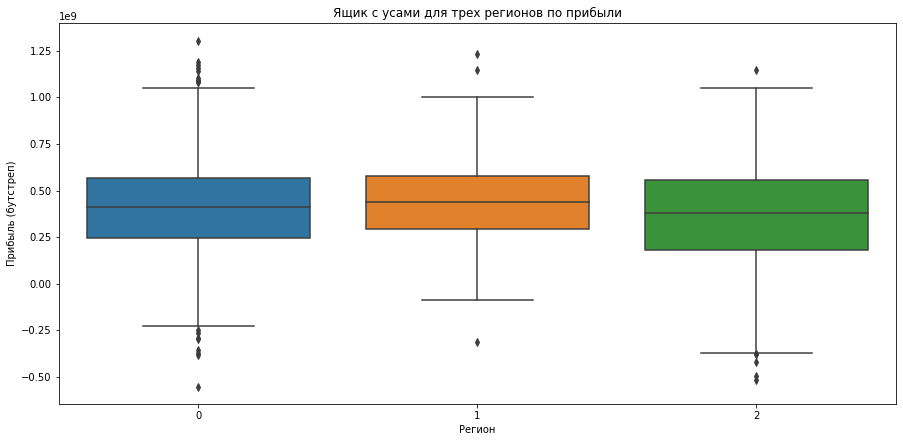

In [51]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=[profits_1, profits_2, profits_3])
plt.xlabel('Регион')
plt.ylabel('Прибыль (бутстреп)')
plt.title('Ящик с усами для трех регионов по прибыли')
plt.show()

Первый и третий регионы имеют наибольший риск убытка > 2.5%, поэтому эти регионы в расчет не берем. Остается только второй регион с самой большой прибылью, но у него были не очень качественные данные. Так что бизнесу нужно сделать выбор между маленькими рисками и некачественными данными и риском побольше, но качественными данными